# Hidden Markov Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from __future__ import division #make division result in floating point result.
%matplotlib inline

I use this table to let me encode states and obervations as integers  

| Index | State | Observation|
|--|---------|------------|
|0 | Depression |Negative|
|1 | Wellness |positive|


State lenghts, X, follow a geometric distrobution with pmf:
$$Pr(X=k) = (1-p)^{k-1}p$$
for k = 1,2,3...  
where p is the probability of leaving the state  
This has a mean $\frac{1}{p}$. This equals 2 and 5 for the depressed and wellness states respectively. Giving a probability transition matrix of:
$$P = \begin{bmatrix}
\frac{1}{2} & \frac{1}{2} \\ \frac{1}{5} & \frac{4}{5} \end{bmatrix} $$

In [2]:
P = np.array([[1/2, 1/2], [1/5, 4/5]])
E = np.array([[.7, .3], [.3, .7]])
obs = [1, 0, 1, 0, 0, 0, 1, 0] # 0 = negative score, 1 = positive score.

In [3]:
def vitermbi(P, E, obs):
    """
    Perform viterbi algoirthm and return the most probable sequence of hidden states
    Parameters
    ----------
    P : Numpy array
        Probability transition matrix for the hidden states
    E : Numpy array
        emission matrix
    obs : list or Numpy array
        observed values
    """
    states = np.arange(len(P))
    V = np.zeros((len(states), len(obs)))
    Ptr = np.zeros((len(states), len(obs)), dtype=np.uint64)
    Ptr[:, 0] = np.array([np.nan, np.nan])
    pi = np.array(((np.mat(P))**1000)[0].flat) #find stationary distro by taking large power of P
    
    for k in states:
        V[k, 0] = pi[k] * E[k, obs[0]] #initialise V using stationary distro of P
    for i, o in enumerate(obs[1:], start=1):
        for m in states:
            l = V[:, i-1] * P[:, m]
            max_index =  np.argmax(l)
            V[m, i] = E[m, o] * l[max_index]
            Ptr[m, i] = max_index 
    
    rho = [np.argmax(V[:, -1])] #initialise rho with max probability pointer
    for p in Ptr[:, ::-1].T[:-1, :]: #traceback
        rho.append(p[rho[-1]])
    return rho[::-1] #reverse rho and return

In [4]:
def forward_backward(P, E, obs):
    """
    Perform forward backward algoirthm and return the a numpy array of posterior probabilities
    Parameters
    ----------
    P : Numpy array
        Probability transition matrix for the hidden states
    E : Numpy array
        emission matrix
    obs : list or Numpy array
        observed values
    """
    states = np.arange(len(P))
    F = np.zeros((len(states), len(obs)))
    B = np.zeros((len(states), len(obs)))
    pi = np.array(((np.mat(P))**1000)[0].flat) #find stationary distro by taking large power of P
    
    for k in states:
        F[k, 0] = pi[k] * E[k, obs[0]] #initialise F using stationary disto of P
    for i, o in enumerate(obs[1:], start=1):  #iterate forward through the observations to calculate F
        for m in states:
            F[m, i] = E[m, o] * sum(F[:, i-1] * P[:, m])
    
    B[:,-1] = np.ones(len(states)) #initialise B as 1's
    for i, o in enumerate(obs[1:][::-1], start=1): #iterate back through the observations to calculate B
        for m in states:
            B[m, -(i+1)] = sum(E[:, o] * B[:, -i] * P[m, :])
    
    Pr_total = sum(F[:,-1])
    # OR: Pr_total = sum(B.T[0] * E[:, obs(0)] * pi)
    Posterior = (F * B)/Pr_total
    return Posterior

In [5]:
post = forward_backward(P, E, obs)
rho = vitermbi(P, E, obs)

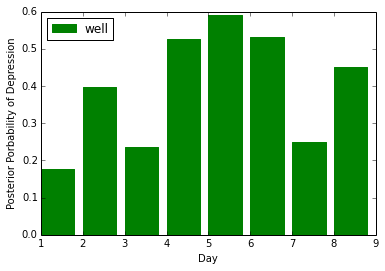

In [6]:
barlist = plt.bar(np.arange(len(obs))+1, post[0]) #Add 1 so that indices start at 1 instead of 0
state_color_list = ['b','g']
for i, r in enumerate(rho):
    barlist[i].set_color(state_color_list[r])
plt.xlabel("Day")
plt.ylabel("Posterior Porbability of Depression")
plt.legend(("well","depressed"), loc='upper left')
plt.show()

In [7]:
post[0, 5] #Probability patient is depressed on day 6 (index = 5)

0.53047503247568506

In [8]:
np.array(((np.mat(P))**1000)[0].flat)

array([ 0.28571429,  0.71428571])

In [9]:
2/7

0.2857142857142857

In [10]:
5/7

0.7142857142857143